In [1]:
!pip install bert-for-tf2
!pip install sentencepiece

In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

In [3]:
!pip install -q tf-models-official

In [4]:
import os
import shutil
import pandas as pd
import numpy as np
import re
import random
import math

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text
from tensorflow.keras import layers
import bert
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


tf.get_logger().setLevel('ERROR')

In [5]:
df_main = pd.read_csv('/content/drive/MyDrive/WSU/Winter 2021/CSC 7810/Final Project/df_main_res.csv')
df_main['review'] = df_main['review'].values.astype('U')
df_main['label'] = df_main['target'].apply(lambda x: "Positive" if x==1 else "Negative")
neg, pos = np.bincount(df_main['target'])

In [6]:
features = df_main['review']
labels = df_main['target']

pos_features = df_main['review'].loc[(df_main['target'] == 1)] 
neg_features = df_main['review'].loc[(df_main['target'] == 0)] 

pos_labels = df_main['target'].loc[(df_main['target'] == 1)] 
neg_labels = df_main['target'].loc[(df_main['target'] == 0)] 

In [7]:

import tensorflow as tf
BUFFER_SIZE = 128
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
seed = 42

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

ds = make_ds(features, labels)


In [8]:
for text_batch, label_batch in ds.take(1):
  print(f'Review: {text_batch}')
  print(f'Review: {label_batch}')

Review: b'experience nexplon great pregnancy yet issue cause much bleeding get period every week month month ruin sex life'
Review: 1


In [9]:
train_size = int(0.7 * 135975)
val_size = int(0.15 * 135975)
test_size = int(0.15 * 135975)

In [10]:
"""

full_dataset = ds.shuffle(buffer_size=128)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)
"""

'\n\nfull_dataset = ds.shuffle(buffer_size=128)\ntrain_dataset = full_dataset.take(train_size)\ntest_dataset = full_dataset.skip(train_size)\nval_dataset = test_dataset.skip(val_size)\ntest_dataset = test_dataset.take(test_size)\n'

In [11]:
#dataset = tf.data.TextLineDataset(["/content/drive/MyDrive/WSU/Winter 2021/CSC 7810/Final Project/df_main_bert.csv"])   

In [12]:
#for text_batch in dataset.take(2):
 # print(text_batch)

In [13]:
"""
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 3
seed = 42

x = tf.data.experimental.make_csv_dataset(
    '/content/drive/MyDrive/WSU/Winter 2021/CSC 7810/Final Project/df_main_bert.csv', 
    batch_size, 
    field_delim=',', 
    na_value='',  
    shuffle=True,
    label_name = 'target'
)
"""

"\nAUTOTUNE = tf.data.AUTOTUNE\nbatch_size = 3\nseed = 42\n\nx = tf.data.experimental.make_csv_dataset(\n    '/content/drive/MyDrive/WSU/Winter 2021/CSC 7810/Final Project/df_main_bert.csv', \n    batch_size, \n    field_delim=',', \n    na_value='',  \n    shuffle=True,\n    label_name = 'target'\n)\n"

In [14]:
#xx=x.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
#examples, labels = next(iter(x)) # Just the first batch.
#print("EXAMPLES: \n", examples, "\n")
#print("LABELS: \n", labels)

In [16]:
#for text_batch, label_batch in xx.take(1):
  #print(text_batch)
  #print(label_batch)

In [17]:
movie_reviews = pd.read_csv("/content/drive/MyDrive/WSU/Winter 2021/CSC 7810/Final Project/df_main_res.csv")

movie_reviews.index = np.arange(1, len(movie_reviews) + 1)

#movie_reviews['target'] = movie_reviews['target'].apply(lambda x: "positive" if x==1 else "negative")

movie_reviews = movie_reviews.rename(columns={"target": "sentiment"})

movie_reviews.isnull().values.any()

movie_reviews.shape

(135975, 2)

In [18]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', str(sentence))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', str(sentence))

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', str(sentence))

    return sentence

In [19]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', str(text))

In [20]:
reviews = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    reviews.append(preprocess_text(sen))

In [21]:
print(movie_reviews.columns.values)

['sentiment' 'review']


In [22]:
movie_reviews.sentiment.unique()

array([1, 0])

In [23]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x==1 else 0, y)))

In [24]:
#@title Choose a BERT model to fine-tune

bert_model_name = "bert_en_uncased_L-12_H-768_A-12" #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [25]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer(tfhub_handle_encoder,
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [26]:
tokenizer.tokenize("don't be so judgmental")

['don', "'", 't', 'be', 'so', 'judgment', '##al']

In [27]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("dont be so judgmental"))

[2123, 2102, 2022, 2061, 8689, 2389]

In [28]:
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

In [29]:
tokenized_reviews = [tokenize_reviews(review) for review in reviews]

In [30]:
# Max length = 1123

In [31]:
reviews_with_len = [[[review[cnt] if cnt < len(review) else 0 for cnt in range(1123)], y[i], len(review)]
                 for i, review in enumerate(tokenized_reviews)]

In [32]:
reviews_with_len.sort(key=lambda x: x[2])


In [33]:
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]


In [34]:
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))


In [35]:
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [36]:
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 1123), dtype=int32, numpy=
 array([[14978,     0,     0, ...,     0,     0,     0],
        [ 4621,     0,     0, ...,     0,     0,     0],
        [ 2307,     0,     0, ...,     0,     0,     0],
        ...,
        [ 2204,     0,     0, ...,     0,     0,     0],
        [21392,     0,     0, ...,     0,     0,     0],
        [ 2307,     0,     0, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>)

In [37]:
TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [38]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [39]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 1

In [40]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [41]:
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

In [42]:
history = text_model.fit(train_data, epochs=NB_EPOCHS)


3825/3825 [==============================] - 302s 73ms/step - loss: 0.6092 - accuracy: 0.6807


In [49]:
loss, accuracy = text_model.evaluate(test_data)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

425/425 [==============================] - 10s 23ms/step - loss: 0.4639 - accuracy: 0.7701
Loss: 0.4638879895210266
Accuracy: 0.7700735330581665


In [50]:
history_dict = history.history
print(history_dict.keys())


dict_keys(['loss', 'accuracy'])


In [47]:
tf.keras.utils.plot_model(text_model, show_shapes=True, show_layer_names=True)
text_model.summary()

Model: "text_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  6104400   
_________________________________________________________________
conv1d (Conv1D)              multiple                  40100     
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  80100     
_________________________________________________________________
global_max_pooling1d (Global multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  77056     
_________________________________________________________________
dropout (Dropout)            multiple                  0

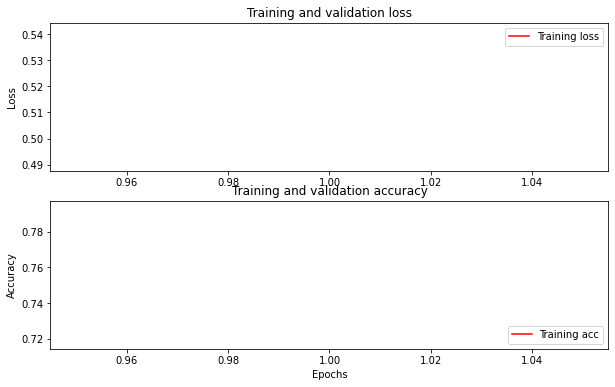

In [51]:

acc = history_dict['accuracy']
#val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
#val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


"""
examples = [
    'this is such an amazing drug!',  # this is the same sentence tried earlier
    'The drug was great!',
    'The drug was meh.',
    'The drug was okish.',
    'The drug was terrible...'
]
"""

examples = 'this is such an amazing drug. I strongly recommend it for people who have this condition.'

In [ ]:
dataset_name = 'imdb'
saved_model_path = '/content/drive/MyDrive'.format(dataset_name.replace('/', '_'))

text_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
xy = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(examples))

In [ ]:
tf.constant(xy)

In [ ]:
reloaded_model.

In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(xy))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

In [ ]:
text_model.evaluate()
